In [2]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 29.1 MB/s eta 0:00:00


In [3]:
import pulp as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Create model
model = pl.LpProblem("Supply_Chain_Optimization", pl.LpMinimize)

# Sets
factories = ["Factory_A", "Factory_B", "Factory_C"]
warehouses = ["Warehouse_1", "Warehouse_2", "Warehouse_3", "Warehouse_4"]
customers = ["Customer_X", "Customer_Y", "Customer_Z", "Customer_W"]

# Parameters
production_capacity = {"Factory_A": 500, "Factory_B": 700, "Factory_C": 600}
warehouse_capacity = {"Warehouse_1": 400, "Warehouse_2": 500, "Warehouse_3": 300, "Warehouse_4": 600}
customer_demand = {"Customer_X": 300, "Customer_Y": 400, "Customer_Z": 350, "Customer_W": 250}

In [4]:
# Costs
production_cost = {"Factory_A": 5, "Factory_B": 6, "Factory_C": 4}
factory_to_warehouse_cost = {
    ("Factory_A", "Warehouse_1"): 3, ("Factory_A", "Warehouse_2"): 2,
    ("Factory_A", "Warehouse_3"): 5, ("Factory_A", "Warehouse_4"): 4,
    ("Factory_B", "Warehouse_1"): 2, ("Factory_B", "Warehouse_2"): 3,
    ("Factory_B", "Warehouse_3"): 2, ("Factory_B", "Warehouse_4"): 3,
    ("Factory_C", "Warehouse_1"): 4, ("Factory_C", "Warehouse_2"): 3,
    ("Factory_C", "Warehouse_3"): 2, ("Factory_C", "Warehouse_4"): 2
}
warehouse_to_customer_cost = {
    ("Warehouse_1", "Customer_X"): 2, ("Warehouse_1", "Customer_Y"): 3,
    ("Warehouse_1", "Customer_Z"): 4, ("Warehouse_1", "Customer_W"): 5,
    ("Warehouse_2", "Customer_X"): 3, ("Warehouse_2", "Customer_Y"): 2,
    ("Warehouse_2", "Customer_Z"): 3, ("Warehouse_2", "Customer_W"): 4,
    ("Warehouse_3", "Customer_X"): 5, ("Warehouse_3", "Customer_Y"): 3,
    ("Warehouse_3", "Customer_Z"): 2, ("Warehouse_3", "Customer_W"): 3,
    ("Warehouse_4", "Customer_X"): 4, ("Warehouse_4", "Customer_Y"): 4,
    ("Warehouse_4", "Customer_Z"): 3, ("Warehouse_4", "Customer_W"): 2
}

In [5]:
# Decision variables
production = {f: pl.LpVariable(f"Produce_{f}", lowBound=0, cat='Continuous') for f in factories}
ship_to_warehouse = {(f, w): pl.LpVariable(f"Ship_{f}_to_{w}", lowBound=0, cat='Continuous')
                    for f in factories for w in warehouses}
ship_to_customer = {(w, c): pl.LpVariable(f"Ship_{w}_to_{c}", lowBound=0, cat='Continuous')
                   for w in warehouses for c in customers}

# Objective function: minimize total cost
model += (
    pl.lpSum([production_cost[f] * production[f] for f in factories]) +
    pl.lpSum([factory_to_warehouse_cost[(f, w)] * ship_to_warehouse[(f, w)]
             for f in factories for w in warehouses]) +
    pl.lpSum([warehouse_to_customer_cost[(w, c)] * ship_to_customer[(w, c)]
             for w in warehouses for c in customers])
)

In [6]:
# Constraints
# Factory capacity
for f in factories:
    model += production[f] <= production_capacity[f], f"Capacity_{f}"

# Production balance
for f in factories:
    model += production[f] == pl.lpSum([ship_to_warehouse[(f, w)] for w in warehouses]), f"Balance_{f}"

# Warehouse capacity
for w in warehouses:
    model += pl.lpSum([ship_to_warehouse[(f, w)] for f in factories]) <= warehouse_capacity[w], f"Capacity_{w}"

# Warehouse flow balance
for w in warehouses:
    model += pl.lpSum([ship_to_warehouse[(f, w)] for f in factories]) == \
            pl.lpSum([ship_to_customer[(w, c)] for c in customers]), f"Flow_{w}"

# Customer demand
for c in customers:
    model += pl.lpSum([ship_to_customer[(w, c)] for w in warehouses]) == customer_demand[c], f"Demand_{c}"

# Solve the model
model.solve()

print(f"Status: {pl.LpStatus[model.status]}")
print(f"Total Cost: ${pl.value(model.objective)}")

Status: Optimal
Total Cost: $11450.0


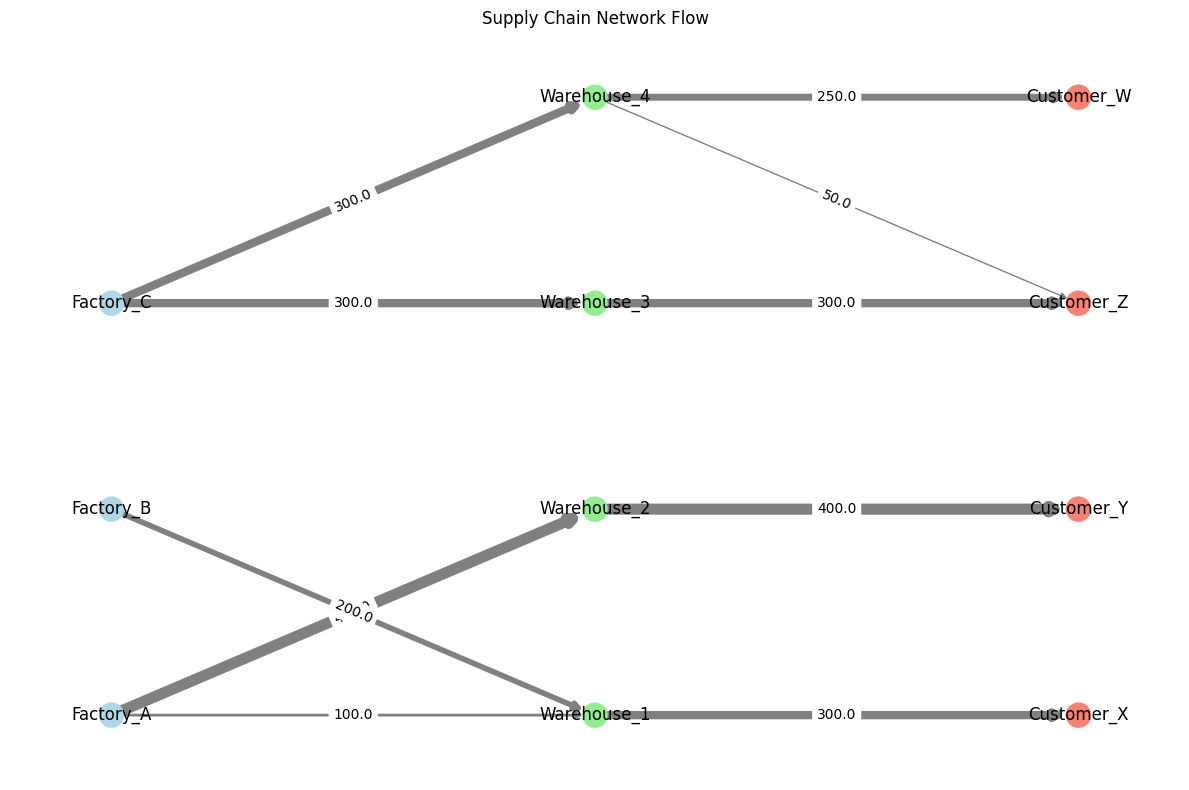

In [7]:
# Visualize the network flow
def plot_network_flow():
    G = nx.DiGraph()

    # Add nodes
    for f in factories:
        G.add_node(f, node_type='factory')
    for w in warehouses:
        G.add_node(w, node_type='warehouse')
    for c in customers:
        G.add_node(c, node_type='customer')

    # Add edges with flow values
    for f in factories:
        for w in warehouses:
            flow = ship_to_warehouse[(f, w)].value()
            if flow > 0:
                G.add_edge(f, w, weight=flow)

    for w in warehouses:
        for c in customers:
            flow = ship_to_customer[(w, c)].value()
            if flow > 0:
                G.add_edge(w, c, weight=flow)

    # Plot the graph
    plt.figure(figsize=(12, 8))
    pos = {**{f: (0, i) for i, f in enumerate(factories)},
           **{w: (1, i) for i, w in enumerate(warehouses)},
           **{c: (2, i) for i, c in enumerate(customers)}}

    node_colors = {**{f: 'lightblue' for f in factories},
                  **{w: 'lightgreen' for w in warehouses},
                  **{c: 'salmon' for c in customers}}

    nx.draw_networkx_nodes(G, pos, node_color=[node_colors[n] for n in G.nodes])
    nx.draw_networkx_labels(G, pos)

    edge_widths = [G[u][v]['weight']/50 for u, v in G.edges]
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray')

    edge_labels = {(u, v): f"{G[u][v]['weight']:.1f}" for u, v in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Supply Chain Network Flow")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_network_flow()